# SQL other joins and subqueries

## Preparation

For this section you need `chinook.db` database file and working `%sql` magic.  
If you don't have it, please go back to the [previous section](../09_sql/connect_to_database.ipynb) and follow the instructions.  
The following code should not produce any errors:

In [1]:
%load_ext sql
%sql sqlite:///chinook.db

Connecting to 'sqlite:///chinook.db'

## `UNION` - merge two tables (right below left)

### Overview

Both `UNION` and `UNION ALL` combine rows from two result sets into a single result set.    
The `UNION` operator removes eliminate duplicate rows, whereas the `UNION ALL` operator does not.

The following are rules to union data:
- The number of columns in both queries must be the same.
- The corresponding columns must have compatible data types.
- The column names of the first query determine the column names of the combined result set.
- The `GROUP BY` and `HAVING` clauses are applied to each individual query, not the final result set.
- The `ORDER BY` clause is applied to the combined result set, not within the individual result set.

*Note:* `JOIN`s combine columns from multiple tables, while `UNION`s combine rows from multiple similar tables.

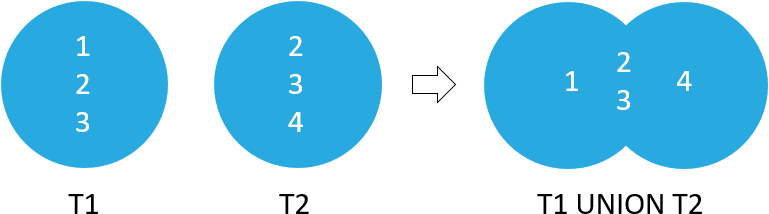

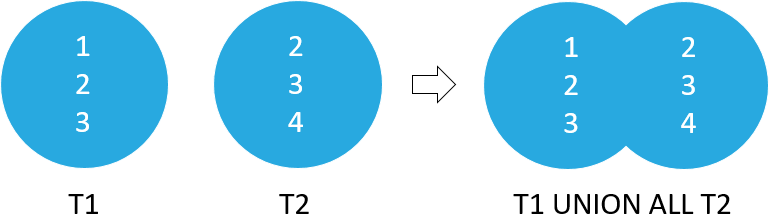

### Example

Let's combine persons from `employees` and `custormes` tables into one table:

In [ ]:
%%sql
  SELECT FirstName, LastName, 'Employee' AS "Group" FROM employees
UNION
  SELECT FirstName, LastName, 'Customer' FROM customers
ORDER BY LastName, FirstName
LIMIT 5

## EXCEPT - rows from the left but not the right table

### Overview

`EXCEPT` returns distinct rows from the left query that are not in the right query:
- The number of columns in the select lists of both queries must be the same.
- The order of the columns and their types must be comparable.

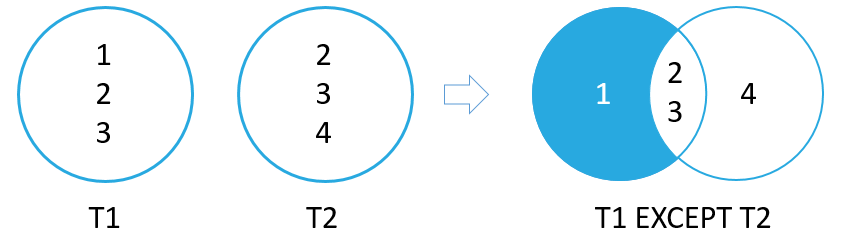

### Example

Let's build a table with the `TrackId` column of all `tracks` which have never been sold (so they are not present among `invoice_items`).  
This problem can be solved differently but for this demonstration we want to use the `EXCEPT` operator.

Let's build a table with all `TrackId`s from `tracks`:

In [2]:
%sql SELECT TrackId FROM tracks LIMIT 5

Running query in 'sqlite:///chinook.db'

TrackId
1
6
7
8
9


And from the above table we will "subtract" a table of `TrackId`s from `invoice_tems`:

In [3]:
%sql SELECT DISTINCT TrackId FROM invoice_items LIMIT 5

Running query in 'sqlite:///chinook.db'

TrackId
1
2
3
4
5


The table of never sold `TrackId`s can be generated as follows:

In [4]:
%%sql
    SELECT TrackId FROM tracks
EXCEPT
    SELECT DISTINCT TrackId FROM invoice_items
  LIMIT 5

Running query in 'sqlite:///chinook.db'

TrackId
7
11
17
18
22


## INERSECT - identical rows present in both tables

### Overview

`INTERSECT` compares the result sets of two queries and returns distinct rows that are output by both queries.
- The number and the order of the columns in both queries must be the same.
- The data types must be comparable.

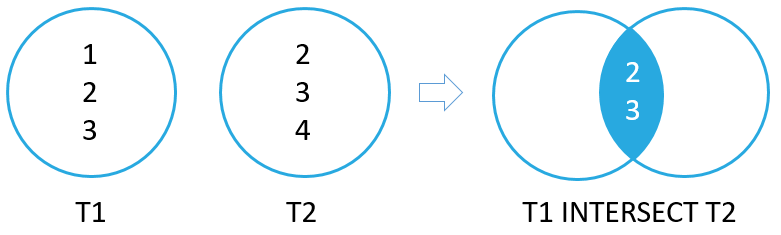

###  Example

Let's build a table with the `TrackId` column of all `tracks` which have been sold (so they are present among `invoice_items`).  
This problem can be solved differently but for this demonstration we want to use the `INTERSECT` operator.

Let's prepare a table of `TrackId`s from `invoice_tems`:

In [ ]:
%sql SELECT DISTINCT TrackId FROM invoice_items LIMIT 5

And as the second table let's use all `TrackId`s from `tracks`:

In [ ]:
%sql SELECT TrackId FROM tracks LIMIT 5

To find the identical rows present in both tables use:

In [ ]:
%%sql
    SELECT DISTINCT TrackId FROM invoice_items
INTERSECT
    SELECT TrackId FROM tracks
  LIMIT 5

## Self-joining (joining a table with itself)

### Overview

The self-join is a special kind of joins that allow you to join a table to itself.  
Because you cannot refer to the same table more than one in a query, you need to use a table alias to assign the table a different name when you use self-join.  
The self-join compares values of the same or different columns in the same table. Only one table is involved in the self-join.

### Example

Each row of the `employee` table describes an emploee but also provides a self-foreign-key to an employee who is the boss.

Let's build a table containing in a single row both the employee full name and the name of the employee's manager.

We start with all rows of the `employees` table. Note, that `NULL` in `ReportsTo` denotes the CEO.

In [ ]:
%sql SELECT EmployeeId, FirstName, LastName, ReportsTo FROM employees

Let's try `INNER JOIN` as follows. Because you use the same `employees` table twice, you need to introduce aliases (here: `e` and `m`) to distinguish the "left" table from the "right" table.

In [ ]:
%%sql
SELECT e.firstname, e.lastname,
       m.firstname, m.lastname
FROM employees e
INNER JOIN employees m ON m.employeeid = e.reportsto

The above is suboptimal. Let's concatenate names and use `AS` to rename columns and clearly denote who is the employee and who the manager:

In [ ]:
%%sql
SELECT e.firstname || ' ' || e.lastname AS "Employee",
       m.firstname || ' ' || m.lastname AS "Manager"
FROM employees e
INNER JOIN employees m ON m.employeeid = e.reportsto

## `CROSS JOIN` - all row-row pairs (not really a join)

### Overview

`CROSS JOIN` simply takes two tables and constructs all possible pairs of the rows from the left table with the rows of the right table.

### Example

Let's assume that there is a need that two `employees` always need to be present and there is a need to produce a table with all possible employee pairs.  
Let's start with names of all `employees`:

In [ ]:
%%sql
SELECT FirstName, LastName FROM employees

Since here we use self-joining `CROSS JOIN` also needs to use table aliases `e1` and `e2`.  
We use the concatenation `||` and aliasing with `AS` to produce two simple columns of names.

In [ ]:
%%sql
SELECT 
    e1.FirstName || ' ' || e1.LastName AS Name1, 
    e2.FirstName || ' ' || e2.LastName AS Name2
  FROM employees e1
  CROSS JOIN employees e2
  LIMIT 10

Note, that `CROSS JOIN` gives all rows vs. all rows, so persons are paired with themselves.
Also, each two persons are paired twice (i.e. X-Y and Y-X). Let's use the following `WHERE` condition to remove identical and repeated pairings:

In [ ]:
%%sql
SELECT 
    e1.FirstName || ' ' || e1.LastName AS Name1, 
    e2.FirstName || ' ' || e2.LastName AS Name2
  FROM employees e1
  CROSS JOIN employees e2
  WHERE Name1 < Name2
  LIMIT 10

## Subquery

### Overview

A subquery is a `SELECT` statement nested in another statement. See the following statement.

```sql
SELECT column_1, ...
FROM table_1
WHERE column_1 = (
   SELECT column_1 
   FROM table_2
)
```

or:

```sql
SELECT column_1, ...
FROM table_1
WHERE column_1 IN (
   SELECT column_1 
   FROM table_2
)
```

You can use a subquery in the `SELECT`, `FROM`, `WHERE`, and `JOIN` clauses.

### Example (suboptimal, assumes a single value from the subquery)

The following statement returns all the `tracks` which have `TrackIds` corresponding to the `albums` with the title equal to `Let There Be Rock`.

The subquery is assumed to return a single `AlbumId` of the album with the title `Let There Be Rock`. For the single returned value, the query uses the equal operator (`=`) to compare `AlbumId` returned by the subquery with the `AlbumId` in the `tracks` table.

In [ ]:
%%sql
SELECT TrackId, Name, AlbumId
  FROM tracks
  WHERE AlbumId = (        -- note the equal operator here
    SELECT AlbumId
    FROM albums
    WHERE Title = 'Let There Be Rock'
  )

### Example (usually better, multiple values can be returned from the subquery)

If the subquery returns multiple values, you can use the `IN` operator to check for the existence of a single value against a set of values.

Let's consider the task of finding the `tracks` whose genre contains the word `Rock`.   
This are the (possibly multiple) `genres` to be considered:

In [ ]:
%sql SELECT * FROM genres WHERE Name LIKE "%Rock%"

So, the `tracks` can be found as follows:

In [ ]:
%%sql
SELECT * FROM tracks 
  WHERE GenreId IN (      -- note the IN operator here
    SELECT GenreId FROM genres WHERE Name LIKE "%Rock%"
  )
  LIMIT 5

## Correlated subquery and `EXISTS` - check whether any row in subquery

### Overview

The `EXISTS` operator is a logical operator that checks whether a subquery returns any row.  
To negate the `EXISTS` operator, you use `NOT EXISTS`.

### Example

Let's consider finding all `artists` which do not have any `albums`.  

In other words: select all `artists` whose `ArtistId`s `NOT EXISTS` among `albums`:

In [ ]:
%%sql
SELECT * FROM artists 
  WHERE NOT EXISTS (
    SELECT * FROM albums WHERE ArtistId = artists.ArtistId
  )
  LIMIT 10

*Note:* the columns of the table from the inner subquery are irrelevant, so to optimize you may return just a single column of `1`s whether any matching result is present:

In [ ]:
%%sql
SELECT * FROM artists 
  WHERE NOT EXISTS (
    SELECT 1 FROM albums WHERE ArtistId = artists.ArtistId
  )
  LIMIT 10